## 0. Importing relevant libraries and creating helper functions

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Create a function that takes a SQL query and converts it into a dataframe
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q,conn)

In [4]:
# Create a function to execute SQL commands
def run_command(cmd):
    with sqlite3.connect('chinook.db') as conn:
        return conn.execute(cmd)

In [5]:
# Create a function to show all tables and views in the database
def show_tables():
    return run_query('''SELECT
                name,
                type
                FROM sqlite_master
                WHERE type IN ("table","view");''')
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## 1. Finding sales by genre in the USA

In [72]:
# Finding the genres that have the most sales in the USA

genre_sales_usa = run_query('''
SELECT
    g.name genre,
    SUM(il.quantity) quantity
FROM genre g
INNER JOIN track tr ON tr.genre_id = g.genre_id
INNER JOIN invoice_line il ON il.track_id = tr.track_id
INNER JOIN invoice i ON i.invoice_id = il.invoice_id
INNER JOIN customer c ON c.customer_id = i.customer_id
WHERE c.country = 'USA'
GROUP BY genre
ORDER BY quantity DESC
''')

genre_sales_usa["quantity(percentage)"] = genre_sales_usa["quantity"]/(genre_sales_usa["quantity"].sum())
genre_sales_usa.set_index('genre', drop = True, inplace = True)
genre_sales_usa

,quantity,quantity(percentage)
genre,,
Rock,561,0.533777
Alternative & Punk,130,0.123692
Metal,124,0.117983
R&B/Soul,53,0.050428
Blues,36,0.034253
Alternative,35,0.033302
Latin,22,0.020932
Pop,22,0.020932
Hip Hop/Rap,20,0.019029


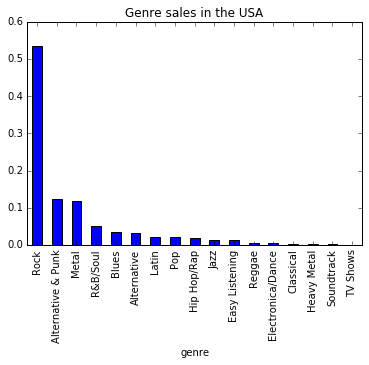

In [73]:
genre_sales_usa["quantity(percentage)"].plot.bar(title = 'Genre sales in the USA')

### From the table and bar chart above, we can see that in the USA Rock is by far the most popular genre, with over 50% of sales being of the Rock genre.  

### My recommendation for the albums that we have a choice of would be Red Tone (Punk), Slim Jim Bites (Blues), and Meteor and the Girls (Pop), though really we would want a new Rock artist.

## 2. Finding the total sales per sales agent

In [74]:
sales_per_agent = run_query('''
SELECT
    e.first_name || " " || e.last_name employee_name,
    e.country employee_country,
    e.title,
    e.hire_date,
    c.country customer_country,
    SUM(i.total) total_sales
FROM employee e
INNER JOIN customer c ON c.support_rep_id = e.employee_id
INNER JOIN invoice i ON i.customer_id = c.customer_id
GROUP BY employee_name
''')
sales_per_agent

,employee_name,employee_country,title,hire_date,customer_country,total_sales
0,Jane Peacock,Canada,Sales Support Agent,2017-04-01 00:00:00,United Kingdom,1731.51
1,Margaret Park,Canada,Sales Support Agent,2017-05-03 00:00:00,USA,1584.00
2,Steve Johnson,Canada,Sales Support Agent,2017-10-17 00:00:00,Canada,1393.92


In [76]:
sales_per_agent.set_index('employee_name', drop = True, inplace = True)

In [77]:
sales_per_agent

,employee_country,title,hire_date,customer_country,total_sales
employee_name,,,,,
Jane Peacock,Canada,Sales Support Agent,2017-04-01 00:00:00,United Kingdom,1731.51
Margaret Park,Canada,Sales Support Agent,2017-05-03 00:00:00,USA,1584.00
Steve Johnson,Canada,Sales Support Agent,2017-10-17 00:00:00,Canada,1393.92


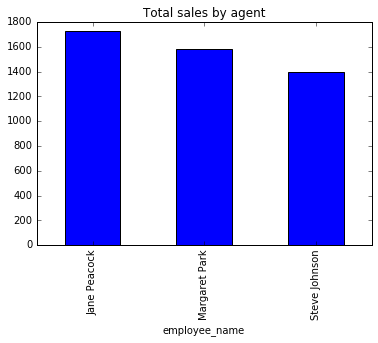

In [78]:
sales_per_agent["total_sales"].plot.bar(title = 'Total sales by agent')

### Jane Peacock had the most sales and Steve Johnson the least.  I added the 'title' and 'employee_country' columns because I thought maybe customers would be more willing to buy if they were talking to either somebody from the same country as them, or someone with a higher title.  However, all 3 sales reps are from Canada, and all hold the same title of "Sales Support Agent".  

### As the total sales is just an aggregate number, however, hiring date is important, and Jane Peacock was hired a month before Margaret Park, and a whole 6 months before Steve Johnson.  Thus, we should be careful to jump to conclusions here and perhaps a "Sales per month" would be a better metric to use.

## 3. Finding sales and customers by country

In [79]:
# First group all countries with 1 customer into "Other"
# Then get summary statistics by summing and dividing by appropriate values
# Then sort the final table by total_sales descending
# Then move the "other" group of countries to the bottom by the "sort" column

sales_by_country = '''
WITH country_or_other AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(customer_id)
                 FROM customer
                 WHERE country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales,
    average_order,
    avg_sale_per_customer
FROM
    (
    SELECT
        country,
        COUNT(DISTINCT customer_id) customers,
        SUM(unit_price) total_sales,
        SUM(unit_price) / COUNT(DISTINCT customer_id) avg_sale_per_customer,
        SUM(unit_price) / COUNT(DISTINCT invoice_id) average_order,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_or_other
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
'''

sales_by_country = run_query(sales_by_country)

In [80]:
sales_by_country

,country,customers,total_sales,average_order,avg_sale_per_customer
0,USA,13,1040.49,7.942672,80.037692
1,Canada,8,535.59,7.047237,66.948750
2,Brazil,5,427.68,7.011148,85.536000
3,France,5,389.07,7.781400,77.814000
4,Germany,4,334.62,8.161463,83.655000
5,Czech Republic,2,273.24,9.108000,136.620000
6,United Kingdom,3,245.52,8.768571,81.840000
7,Portugal,2,185.13,6.383793,92.565000
8,India,2,183.15,8.721429,91.575000
9,Other,15,1094.94,7.448571,72.996000


In [92]:
sales_by_country.set_index('country', drop = True, inplace = True)

In [94]:
sales_by_country = sales_by_country.iloc[:-1]

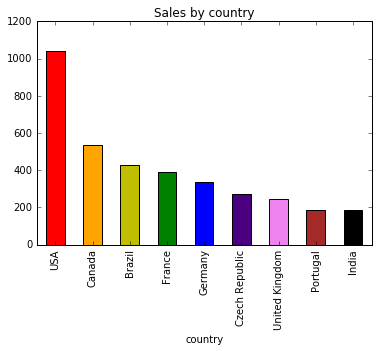

In [101]:
# Plotting the total sales by country

country_colors = ['r','orange','y','g','b','indigo','violet','brown','black']
sales_by_country["total_sales"].plot.bar(title = 'Sales by country', 
color = country_colors)

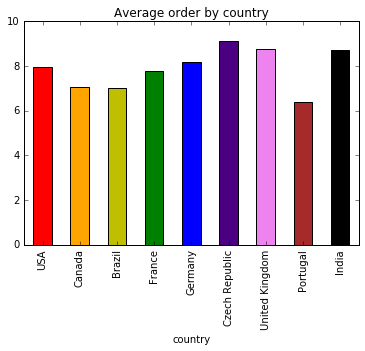

In [102]:
# Plotting the average order size by country

sales_by_country["average_order"].plot.bar(title = 'Average order by country', 
color = country_colors)

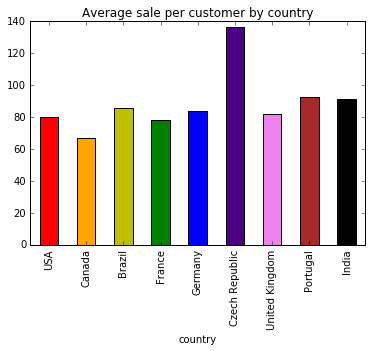

In [103]:
# Plotting average sale per customer by country

sales_by_country["avg_sale_per_customer"].plot.bar(title = 'Average sale per customer by country', 
color = country_colors)

### Although the USA has the most total sales, it's average number of orders and average sale per customer are middle of the pack at best.

### The Czech Republic has both the highest average number of orders and the highest average sale per customer.  Likewise, India has the 3rd largest average order and 3rd highest average sale per customer.

### I would focus on marketing to get more customers in the Czech Republic and India as I believe these countries have the greatest potential for growth.  The only concern is that both India and the Czech Republic have only 2 customers each, which is a very small sample size.  